Evaluating trained tuned lens.
Tuned lens vs logit lens comparison for a couple of examples

In [6]:
%config InlineBackend.figure_format='retina'
from IPython.display import clear_output
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from nnsight import LanguageModel, CONFIG

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [7]:
# Load llama3.1
MODEL_PATH="meta-llama/Meta-Llama-3.1-8B"
llama = LanguageModel(MODEL_PATH)

In [8]:
llama.model.layers

ModuleList(
  (0-31): 32 x LlamaDecoderLayer(
    (self_attn): LlamaSdpaAttention(
      (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
      (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
      (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
      (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
      (rotary_emb): LlamaRotaryEmbedding()
    )
    (mlp): LlamaMLP(
      (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
      (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
      (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
    (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
  )
)

In [9]:
# All we need to specify using NDIF vs executing locally is remote=True.
with llama.trace("The Big Ben is located in the city of", remote=True) as runner:

    hidden_states = llama.model.layers[-1].output.save()

    output = llama.output.save()
    t1_tokens_out = llama.lm_head.output.argmax(dim=-1).save()

print(hidden_states)

print(output["logits"])
print(t1_tokens_out)
print("Original Prediction: ", llama.tokenizer.decode(t1_tokens_out[0][-1]))

2024-10-23 22:00:57,137 a2002de2-d13c-4247-8d62-02c4cb17b465 - RECEIVED: Your job has been received and is waiting approval.


2024-10-23 22:00:57,175 a2002de2-d13c-4247-8d62-02c4cb17b465 - APPROVED: Your job was approved and is waiting to be run.
2024-10-23 22:00:57,197 a2002de2-d13c-4247-8d62-02c4cb17b465 - RUNNING: Your job has started running.
2024-10-23 22:00:57,406 a2002de2-d13c-4247-8d62-02c4cb17b465 - COMPLETED: Your job has been completed.

(tensor([[[ 1.7734,  2.6875,  0.8047,  ..., -1.8594,  2.2344,  3.2812],
         [ 0.0352, -0.0430, -2.8750,  ..., -0.8906, -0.0508,  1.6094],
         [-0.1953,  0.3652, -0.0957,  ..., -0.4102,  0.1953,  0.9570],
         ...,
         [ 1.1328, -0.3926, -1.8906,  ..., -0.9648,  0.4414,  0.4336],
         [ 1.5312,  0.6094, -0.9688,  ..., -0.3945, -0.0547, -0.9062],
         [ 0.8359, -0.7500, -1.2344,  ..., -0.8633,  0.7852, -1.6250]]],
       dtype=torch.bfloat16), DynamicCache())
tensor([[[ 6.3438,  8.3750, 12.8125,  ..., -4.3750, -4.3750, -4.3750],
         [-2.4531, -1.7031, -2.0000,  ..., -9.1250, -9.1250, -9.1250],
         [ 4.2812,  2.6094,  1.9141,  ..., -5.7500, -5.7500, -5.7500],
         ...,
         [ 2.5938,  4.1875,  0.2373,  ..., -6.1875, -6.1875, -6.1875],
         [ 9.5000,  6.4375,  4.7500,  ..., -2.3906, -2.3906, -2.3906],
         [ 4.5938,  3.9844,  1.0234,  ..., -6.8750, -6.8750, -6.8750]]])
tensor([[14924,   220, 17343,   374,   264,   304,   279,  4851,   31

In [10]:
import matplotlib.pyplot as plt
def plot_prob():
    plt.figure(figsize=(10, 6))
    texts = []  # List to hold text annotations for adjustment

    # Get the default color cycle from Matplotlib
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    print(color_cycle)

plot_prob()

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


<Figure size 1000x600 with 0 Axes>

In [11]:
def run_prompt_get_residual(model,PROMPT):
    residuals_by_layer = []
    input_ids = model.tokenizer.encode(PROMPT)
    with model.trace(input_ids, remote=True) as runner:
        for layer_ix,layer in enumerate(model.model.layers):
            residual = layer.output[0][:, -1, :].save()
            residuals_by_layer.append(residual)
        tokens_out = llama.lm_head.output.argmax(dim=-1).save()
        expected_token = tokens_out[0][-1].save()
    return residuals_by_layer,expected_token

In [12]:
# PROMPT = "The Eiffel Tower is in the city of"
PROMPT = 'The Big Ben is located in the city of'
residuals_by_layer,expected_token=run_prompt_get_residual(llama,PROMPT)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
2024-10-23 22:00:57,803 076fcc73-76da-42d2-9aa7-ffcab40f9c1c - RECEIVED: Your job has been received and is waiting approval.
2024-10-23 22:00:57,836 076fcc73-76da-42d2-9aa7-ffcab40f9c1c - APPROVED: Your job was approved and is waiting to be run.
2024-10-23 22:00:57,843 076fcc73-76da-42d2-9aa7-ffcab40f9c1c - RUNNING: Your job has started running.
2024-10-23 22:00:57,955 076fcc73-76da-42d2-9aa7-ffcab40f9c1c - COMPLETED: Your job has been completed.


In [13]:
actual_output = llama.tokenizer.decode(expected_token.item())
actual_output

' London'

In [14]:
for layer_idx,residual in enumerate(residuals_by_layer):
    print(f"Layer {layer_idx}")
    print(residual)

Layer 0
tensor([[-0.0103,  0.0036,  0.0014,  ..., -0.0266, -0.0095,  0.0266]],
       dtype=torch.bfloat16)
Layer 1
tensor([[ 0.0098, -0.0140, -0.0342,  ..., -0.0903,  0.0038,  0.0266]],
       dtype=torch.bfloat16)
Layer 2
tensor([[-0.0060,  0.0148, -0.0415,  ..., -0.0972, -0.0210,  0.0056]],
       dtype=torch.bfloat16)
Layer 3
tensor([[-0.0117, -0.0034, -0.0615,  ..., -0.1147,  0.0076,  0.0376]],
       dtype=torch.bfloat16)
Layer 4
tensor([[-0.0103,  0.0420, -0.0449,  ..., -0.1240, -0.0247,  0.0898]],
       dtype=torch.bfloat16)
Layer 5
tensor([[ 0.0001,  0.0127, -0.0571,  ..., -0.0137,  0.0248,  0.0752]],
       dtype=torch.bfloat16)
Layer 6
tensor([[-0.0757,  0.0236, -0.0820,  ...,  0.0393, -0.0217,  0.0280]],
       dtype=torch.bfloat16)
Layer 7
tensor([[-0.0776,  0.0247, -0.0425,  ..., -0.0029,  0.0003,  0.0508]],
       dtype=torch.bfloat16)
Layer 8
tensor([[-0.0117,  0.0130, -0.0879,  ...,  0.0381, -0.0297,  0.0288]],
       dtype=torch.bfloat16)
Layer 9
tensor([[ 0.1074, -0

In [15]:
import torch.nn as nn
class TunedLensTransformation(nn.Module):
    def __init__(self, d_model: int) -> None:
        super().__init__()
        self.translator = nn.Linear(d_model, d_model)
        # initialize to identity
        nn.init.eye_(self.translator.weight)
        self.translator.bias.data.zero_()

    def forward(self, x):
        self.translator.to(x.dtype)
        return self.translator(x)

def load_lenses(model, lens_checkpoint_path):
    num_layers = len(model.model.layers)
    lenses = []
    for i in range(num_layers):
        lens = TunedLensTransformation(model.config.hidden_size)
        lens.load_state_dict(
            torch.load(f"{lens_checkpoint_path}/tuned_lens_trained_{i}.pth")
        )
        lens.eval()
        lenses.append(lens)

    return lenses


In [16]:
lens_checkpoint_path="/mnt/ssd/aryawu/prl_ml/finewebedu_10000_out"
lenses = load_lenses(llama, lens_checkpoint_path)

/tmp/ipykernel_1564996/2382349786.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f"{lens_checkpoint_path}/tuned_lens_trained_{i}.pth")


In [17]:
def run_tuned_lens(residuals_by_layer,lenses):
    results_list = []
    for layer_idx,residual in enumerate(residuals_by_layer):
        # print(lenses[layer_idx])
        translated = lenses[layer_idx](residual)
        print(f"Layer {layer_idx}")
        print("Original Residual")
        print(residual)
        print("Translated Residual")
        print(translated)
        results_list.append(translated)
    return results_list

In [18]:
results_list=run_tuned_lens(residuals_by_layer,lenses)

Layer 0
Original Residual
tensor([[-0.0103,  0.0036,  0.0014,  ..., -0.0266, -0.0095,  0.0266]],
       dtype=torch.bfloat16)
Translated Residual
tensor([[-0.0168, -0.0199,  0.0046,  ..., -0.0250, -0.0193,  0.0403]],
       dtype=torch.bfloat16, grad_fn=<AddmmBackward0>)
Layer 1
Original Residual
tensor([[ 0.0098, -0.0140, -0.0342,  ..., -0.0903,  0.0038,  0.0266]],
       dtype=torch.bfloat16)
Translated Residual
tensor([[ 0.0075, -0.0383, -0.0288,  ..., -0.0894, -0.0016,  0.0469]],
       dtype=torch.bfloat16, grad_fn=<AddmmBackward0>)
Layer 2
Original Residual
tensor([[-0.0060,  0.0148, -0.0415,  ..., -0.0972, -0.0210,  0.0056]],
       dtype=torch.bfloat16)
Translated Residual
tensor([[-0.0092, -0.0178, -0.0381,  ..., -0.0947, -0.0189,  0.0282]],
       dtype=torch.bfloat16, grad_fn=<AddmmBackward0>)
Layer 3
Original Residual
tensor([[-0.0117, -0.0034, -0.0615,  ..., -0.1147,  0.0076,  0.0376]],
       dtype=torch.bfloat16)
Translated Residual
tensor([[-0.0143, -0.0364, -0.0620,  .

In [19]:
def unembed_tuned(model,results_list,expected_token):
    tuned_lens_token_result_by_layer = []
    tuned_lens_probs_by_layer = []
    tuned_lens_ranks_by_layer = []
    with torch.no_grad():
        with model.trace('',remote=True) as tracer:
            for translated in results_list:
                normed_last_token_residual= model.model.norm(translated)
                tuned_lens_token_distribution= model.lm_head(normed_last_token_residual).save()
                tuned_lens_last_token_logit = tuned_lens_token_distribution[-1:]
                tuned_lens_probs = F.softmax(tuned_lens_last_token_logit, dim=1).save()
                tuned_lens_probs_by_layer.append(tuned_lens_probs)
                tuned_lens_next_token = torch.argmax(tuned_lens_probs, dim=1).save()
                tuned_lens_token_result_by_layer.append(tuned_lens_next_token)
    tuned_lens_all_probs = np.concatenate([probs[:, expected_token].cpu().detach().to(torch.float32).numpy() for probs in tuned_lens_probs_by_layer])

    for layer_probs in tuned_lens_probs_by_layer:
        # Sort the probabilities in descending order and find the rank of the expected token
        sorted_probs, sorted_indices = torch.sort(layer_probs, descending=True)
        # Find the rank of the expected token (1-based rank)
        expected_token_rank = (sorted_indices == expected_token).nonzero(as_tuple=True)[1].item() + 1
        tuned_lens_ranks_by_layer.append(expected_token_rank)
    actual_output = model.tokenizer.decode(expected_token.item())
    tuned_lens_results = [model.tokenizer.decode(next_token.item()) for next_token in tuned_lens_token_result_by_layer]
    return tuned_lens_results, tuned_lens_all_probs, actual_output,tuned_lens_ranks_by_layer


In [20]:
tuned_lens_results, tuned_lens_all_probs, actual_output,tuned_lens_ranks_by_layer=unembed_tuned(llama,results_list,expected_token)

2024-10-23 22:01:04,139 f0f59758-0fab-455f-841b-ed4b65bccec1 - RECEIVED: Your job has been received and is waiting approval.
2024-10-23 22:01:04,145 f0f59758-0fab-455f-841b-ed4b65bccec1 - APPROVED: Your job was approved and is waiting to be run.
2024-10-23 22:01:04,162 f0f59758-0fab-455f-841b-ed4b65bccec1 - RUNNING: Your job has started running.
2024-10-23 22:01:04,609 f0f59758-0fab-455f-841b-ed4b65bccec1 - COMPLETED: Your job has been completed.


In [21]:
tuned_lens_results

[' the',
 ' the',
 ' the',
 ' ',
 ' city',
 ' ',
 ' ',
 ' K',
 ' the',
 ' K',
 ' C',
 ' the',
 ' British',
 ' British',
 ' British',
 ' British',
 ' British',
 ' London',
 ' London',
 ' London',
 ' London',
 ' London',
 ' London',
 ' London',
 ' London',
 ' London',
 ' London',
 ' London',
 ' London',
 ' London',
 ' London',
 ' London']

In [22]:
tuned_lens_all_probs

array([1.3923645e-04, 2.9945374e-04, 2.3269653e-04, 2.9563904e-04,
       3.9100647e-04, 8.5353851e-05, 3.3378601e-05, 6.8664551e-05,
       2.6130676e-04, 1.9168854e-04, 3.7689209e-03, 4.1809082e-03,
       3.5552979e-03, 5.8288574e-03, 1.4831543e-02, 3.5156250e-02,
       9.0332031e-02, 5.5468750e-01, 6.5234375e-01, 5.8593750e-01,
       5.3515625e-01, 6.7968750e-01, 5.3515625e-01, 5.5468750e-01,
       8.5937500e-01, 8.6328125e-01, 8.5546875e-01, 8.7500000e-01,
       8.8281250e-01, 8.6718750e-01, 7.9296875e-01, 7.7343750e-01],
      dtype=float32)

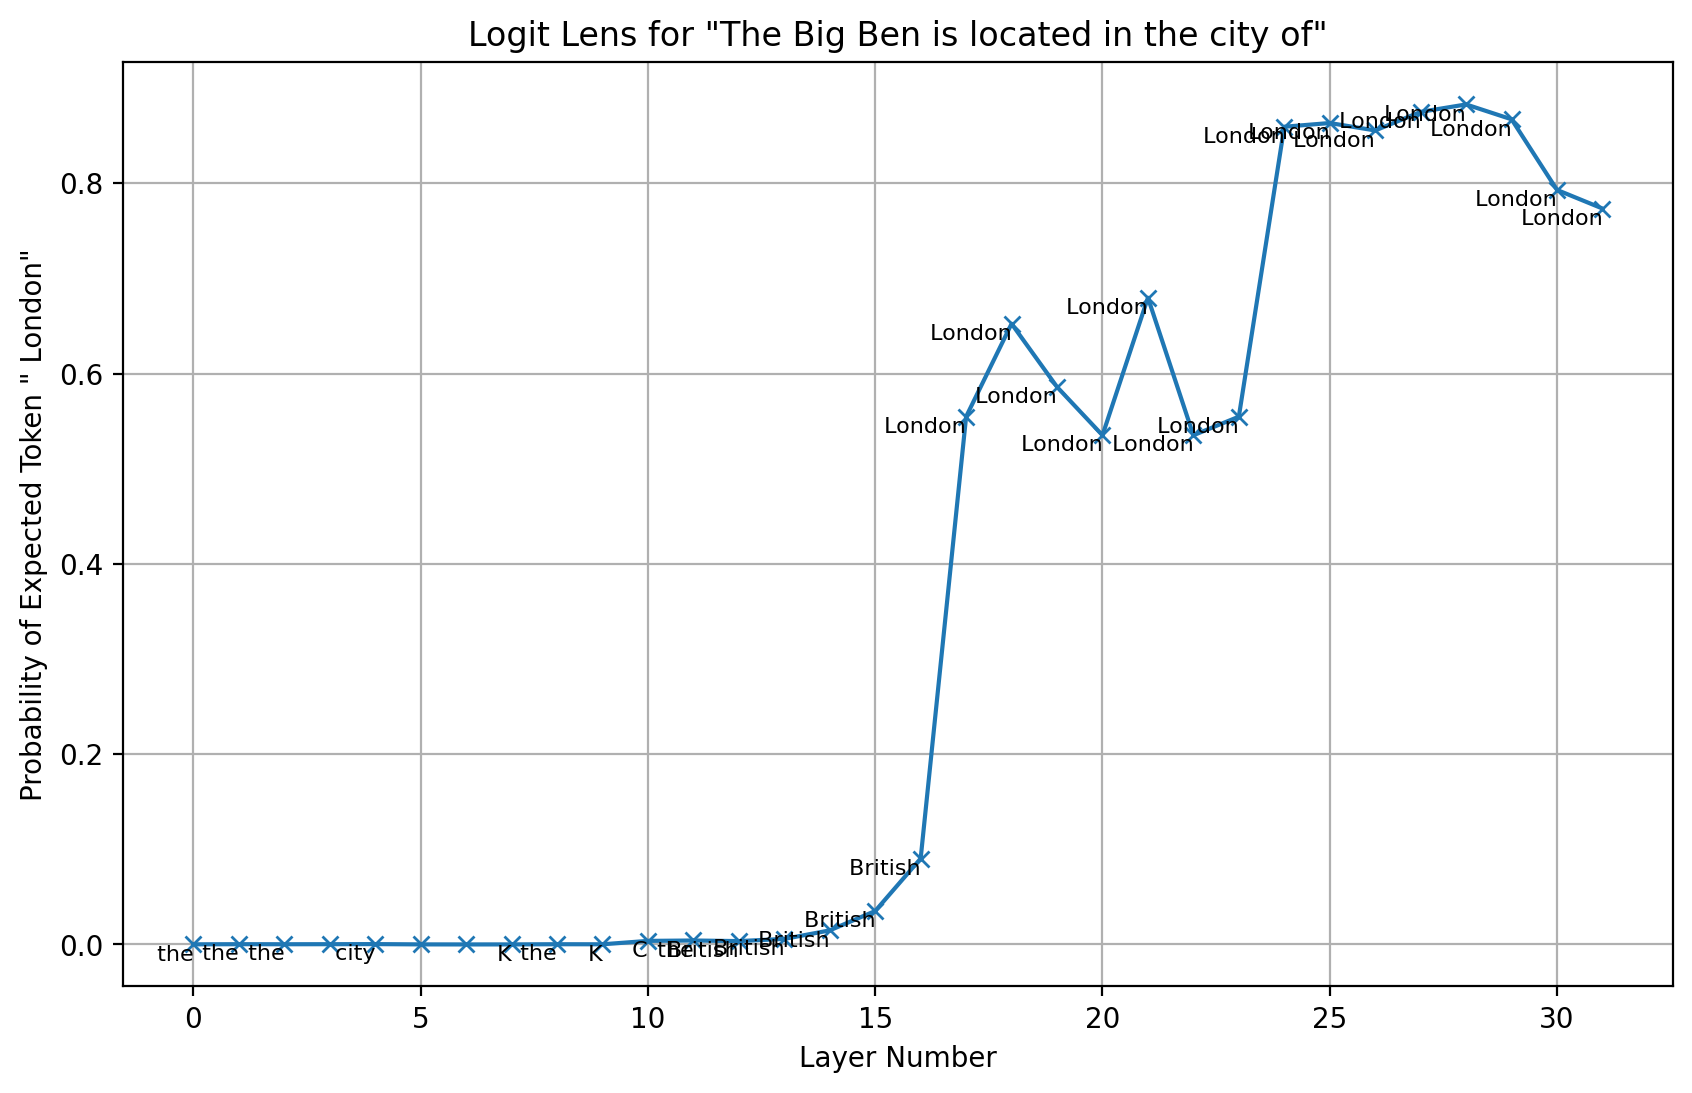

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
def plot__lens(logit_lens_all_probs,logit_lens_results,actual_output):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(logit_lens_all_probs)), logit_lens_all_probs, marker='x')

    for layer_number, next_token in enumerate(logit_lens_results):
        plt.text(layer_number, logit_lens_all_probs[layer_number], next_token, ha='right', va='top',fontsize=8)

    plt.xlabel('Layer Number')
    plt.ylabel(f'Probability of Expected Token "{actual_output}"')
    plt.title(f'Logit Lens for "{PROMPT}"')
    plt.grid(True)
    plt.show()

plot__lens(tuned_lens_all_probs,tuned_lens_results,actual_output)

In [24]:
def plot_rank(tuned_lens_ranks_by_layer):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(tuned_lens_ranks_by_layer)), tuned_lens_ranks_by_layer, marker='x')
    for layer_number, rank in enumerate(tuned_lens_ranks_by_layer):
        plt.text(layer_number, rank, rank, ha='right', va='top',fontsize=8)
    plt.xlabel('Layer Number')
    plt.ylabel('Rank of Expected Token')
    plt.title(f'Rank of Expected Token "{actual_output}"')
    plt.grid(True)
    plt.show()

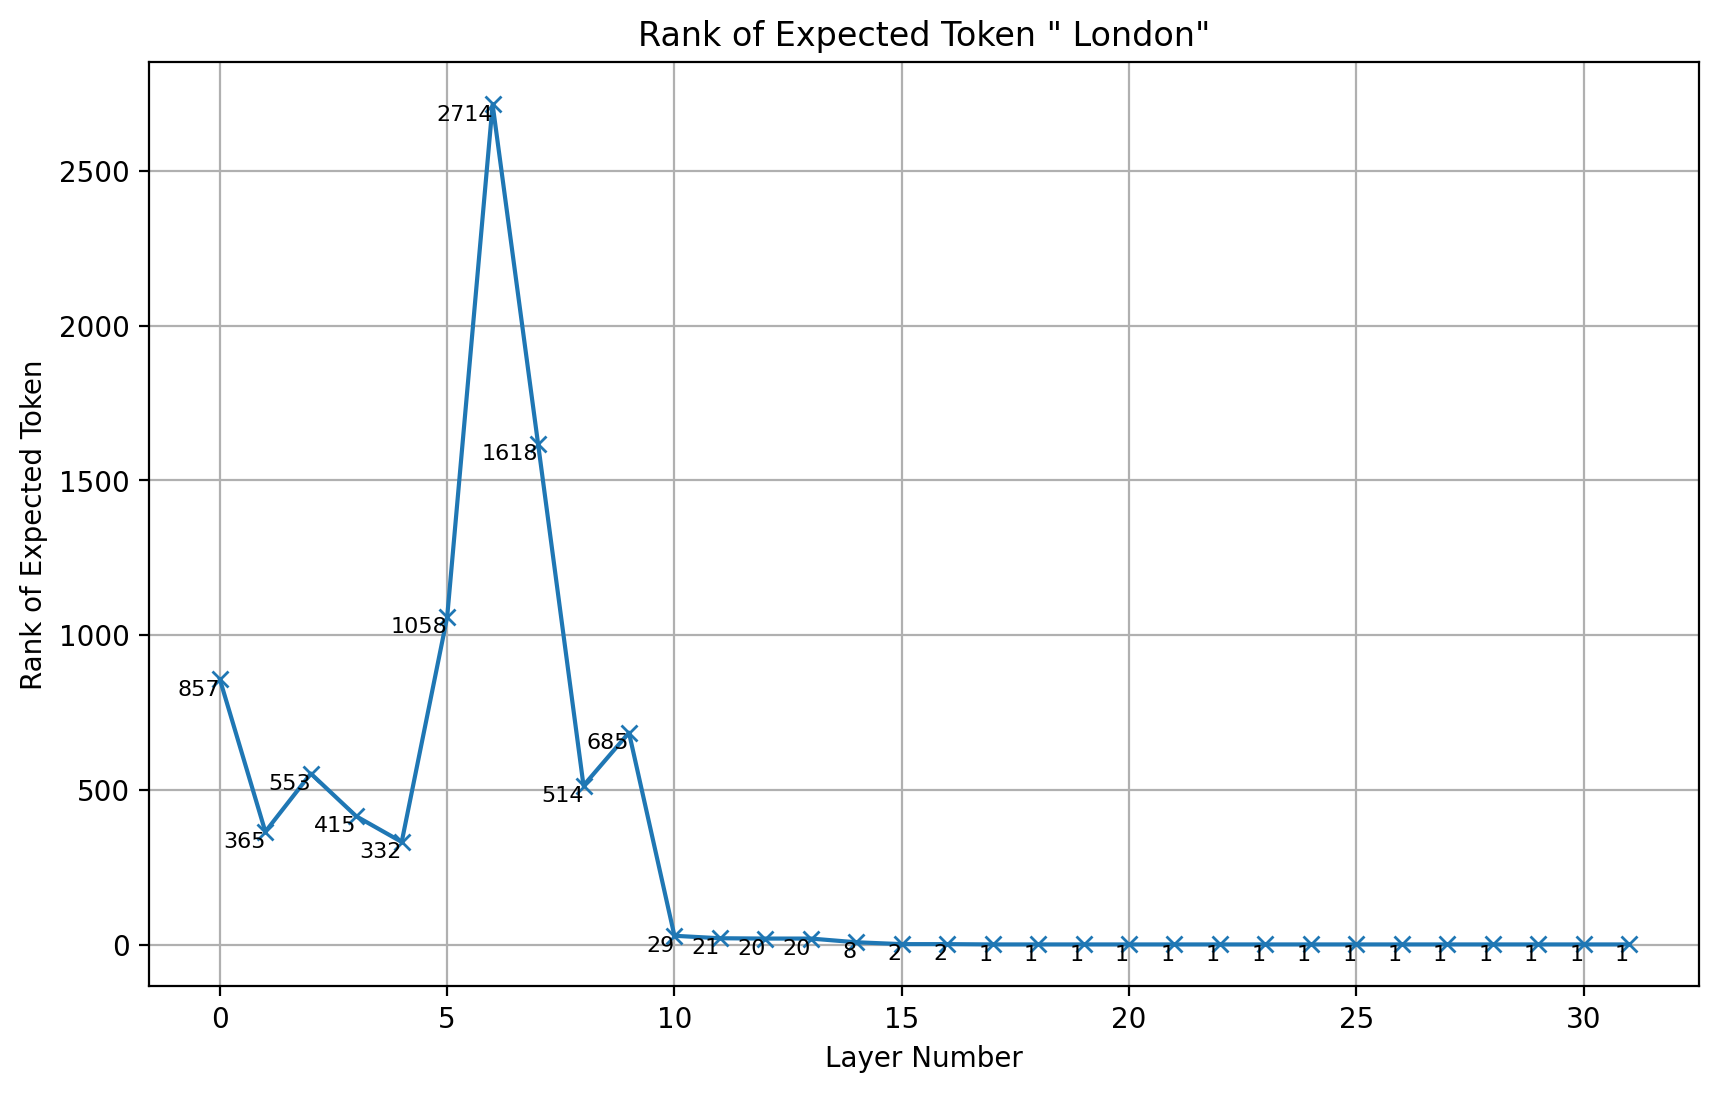

In [25]:
plot_rank(tuned_lens_ranks_by_layer)

In [26]:
import torch.nn.functional as F
import numpy as np
def run_lens(model,PROMPT):
    logit_lens_token_result_by_layer = []
    logit_lens_probs_by_layer = []
    logit_lens_ranks_by_layer = []
    input_ids = model.tokenizer.encode(PROMPT)
    with model.trace(input_ids, remote=True) as runner:
        for layer_ix,layer in enumerate(model.model.layers):
            hidden_state = layer.output[0][0]
            logit_lens_normed_last_token = model.model.norm(hidden_state)
            logit_lens_token_distribution = model.lm_head(logit_lens_normed_last_token)
            logit_lens_last_token_logit = logit_lens_token_distribution[-1:]
            logit_lens_probs = F.softmax(logit_lens_last_token_logit, dim=1).save()
            logit_lens_probs_by_layer.append(logit_lens_probs)
            logit_lens_next_token = torch.argmax(logit_lens_probs, dim=1).save()
            logit_lens_token_result_by_layer.append(logit_lens_next_token)
        tokens_out = llama.lm_head.output.argmax(dim=-1).save()
        expected_token = tokens_out[0][-1].save()
    # logit_lens_all_probs = np.concatenate([probs[:, expected_token].cpu().detach().numpy() for probs in logit_lens_probs_by_layer])
    logit_lens_all_probs = np.concatenate([probs[:, expected_token].cpu().detach().to(torch.float32).numpy() for probs in logit_lens_probs_by_layer])

    #get the rank of the expected token from each layer's distribution
    for layer_probs in logit_lens_probs_by_layer:
        # Sort the probabilities in descending order and find the rank of the expected token
        sorted_probs, sorted_indices = torch.sort(layer_probs, descending=True)
        # Find the rank of the expected token (1-based rank)
        expected_token_rank = (sorted_indices == expected_token).nonzero(as_tuple=True)[1].item() + 1
        logit_lens_ranks_by_layer.append(expected_token_rank)
    # print("logit_lens_ranks_by_layer: ", logit_lens_ranks_by_layer)
    actual_output = llama.tokenizer.decode(expected_token.item())
    logit_lens_results = [model.tokenizer.decode(next_token.item()) for next_token in logit_lens_token_result_by_layer]
    return logit_lens_results, logit_lens_all_probs, actual_output,logit_lens_ranks_by_layer

In [27]:
logit_lens_results, logit_lens_all_probs, actual_output,logit_lens_ranks_by_layer = run_lens(llama,PROMPT)

2024-10-23 22:01:05,900 cac09f84-d3db-4aae-ac30-aab0dfc47043 - RECEIVED: Your job has been received and is waiting approval.
2024-10-23 22:01:05,931 cac09f84-d3db-4aae-ac30-aab0dfc47043 - APPROVED: Your job was approved and is waiting to be run.
2024-10-23 22:01:05,942 cac09f84-d3db-4aae-ac30-aab0dfc47043 - RUNNING: Your job has started running.
2024-10-23 22:01:06,209 cac09f84-d3db-4aae-ac30-aab0dfc47043 - COMPLETED: Your job has been completed.


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
def plot_two_lens(all_probs, logit_lens_all_probs, results, logit_lens_results,PROMPT):
    warnings.filterwarnings("ignore", "Glyph .* missing from font", UserWarning)
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(all_probs)), all_probs, marker='o')
    plt.plot(range(len(logit_lens_all_probs)), logit_lens_all_probs, marker='x')

    # Label each point with its corresponding alphabet output
    for layer_number, next_token in enumerate(results):
        plt.text(layer_number, all_probs[layer_number], next_token, ha='right', va='bottom')

    for layer_number, next_token in enumerate(logit_lens_results):
        plt.text(layer_number, logit_lens_all_probs[layer_number], next_token, ha='right', va='top',fontsize=8)


    plt.xlabel('Layer Number')
    plt.ylabel('Probability of Expected Token')
    plt.title(f'Tuned Lens vs Logit Lens for "{PROMPT}"')
    plt.grid(True)
    plt.show()

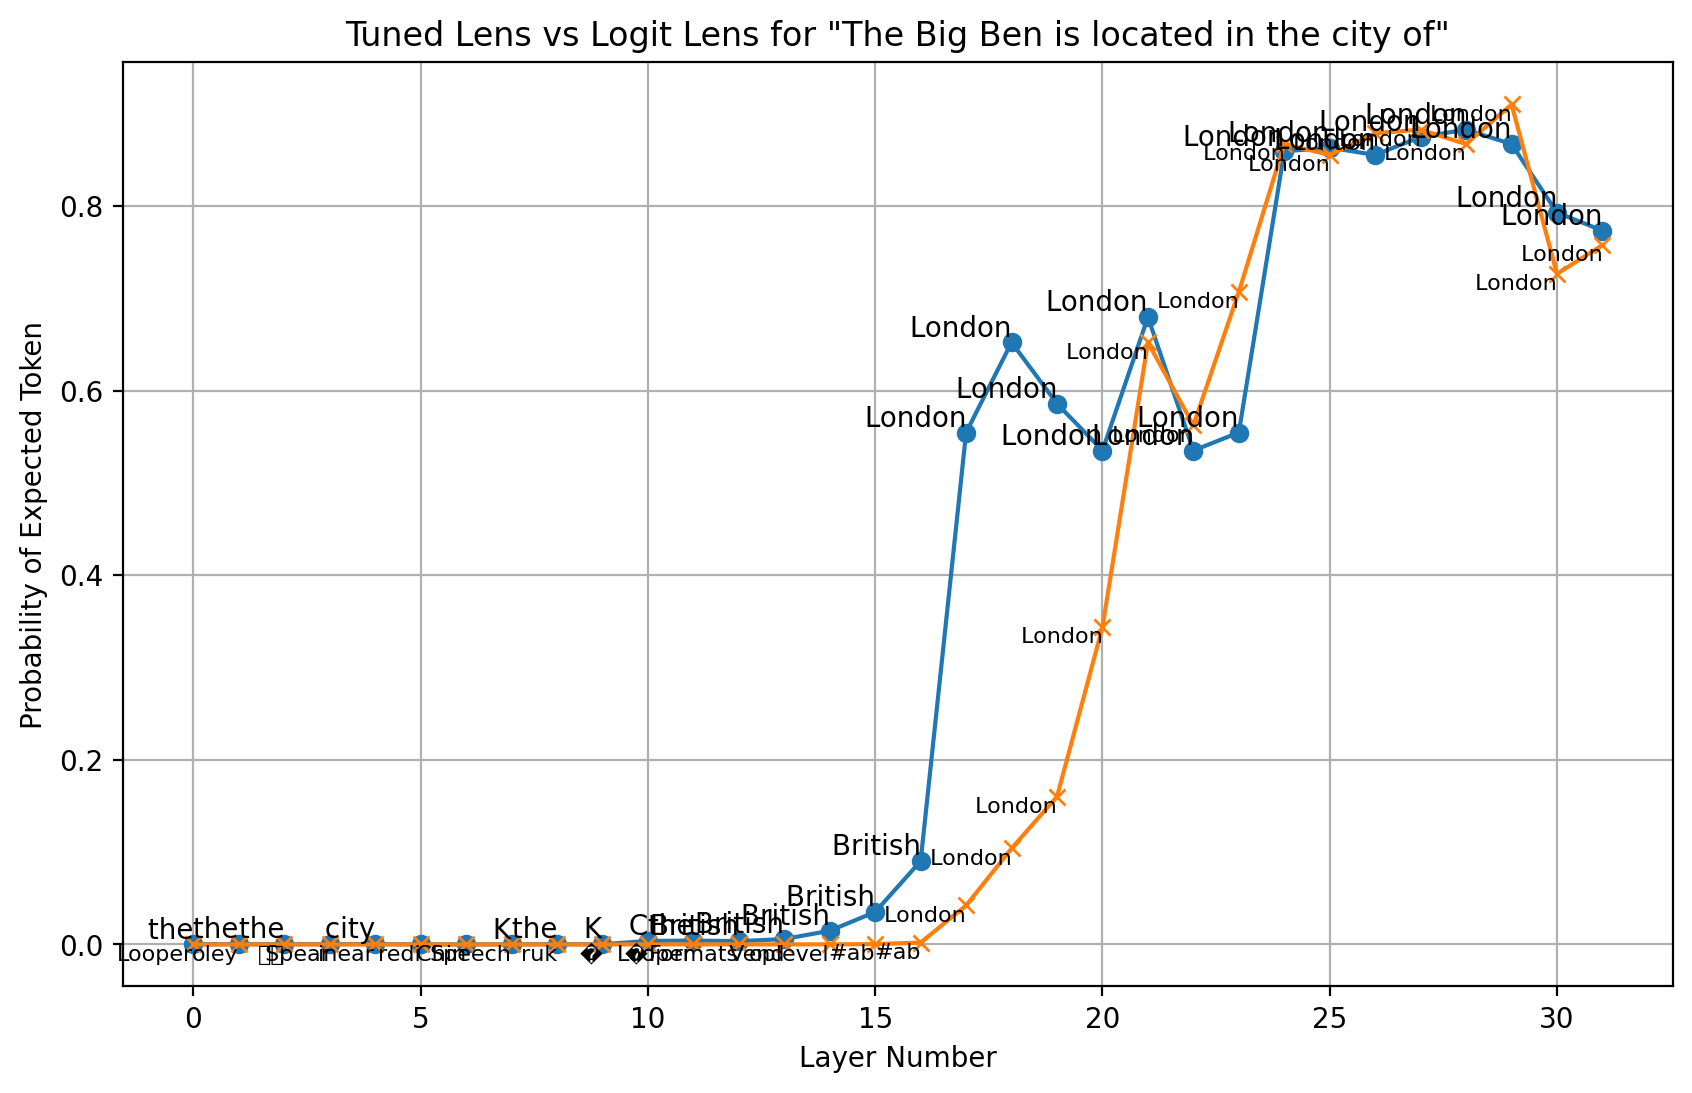

In [29]:
plot_two_lens(tuned_lens_all_probs, logit_lens_all_probs, tuned_lens_results, logit_lens_results,PROMPT)